<a href="https://colab.research.google.com/github/Actulus/MI/blob/main/lab3/Lab3_MLP_StepBYStep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLP szerkezete:

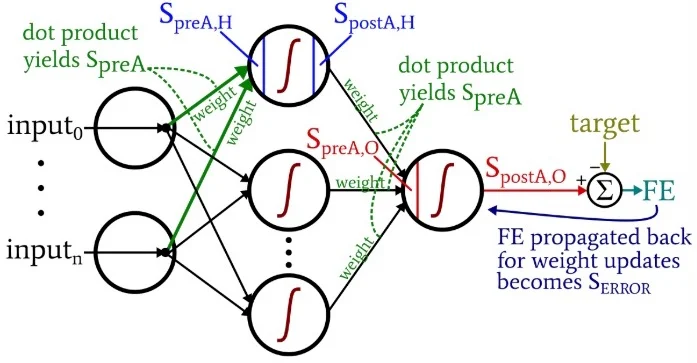

A NumPy könyvtárat széles körben használják a hálózat számításaihoz, a Pandas könyvtár pedig kényelmes módot biztosít edzési adatok importálására Excel fájlból.

In [1]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Amint azt már tudja, a logisztikus szigmoid funkciót használjuk az aktiváláshoz. Magára a logisztikus függvényre van szükségünk a posztaktivációs értékek számításához, a logisztikus függvény deriváltjára pedig a visszaterjesztéshez.

In [2]:
def sigmoidFunction(x):
    return 1.0/(1 + np.exp(-x))

def sigmoidFunctionDeriv(x):
    return sigmoidFunction(x) * (1 - sigmoidFunction(x))

Ezután kiválasztjuk a tanulási sebességet, a bemeneti réteg dimenzióját, a rejtett réteg dimenzióját és az epochok számát.

In [3]:
LR = 1

I_dim = 3
H_dim = 4

epoch_count = 1

Az np.random.uniform() függvény kitölti a mi két súlymátrixunkat –1 és +1 közötti véletlenszerű értékekkel. (Megjegyezzük, hogy a rejtett-kimeneti mátrix valójában csak egy tömb, mert csak egy kimeneti csomópontunk van.) Az np.random.seed(1) utasítás azt eredményezi, hogy a véletlen értékek a program minden egyes futtatásakor ugyanazok lesznek. A kezdeti súlyértékek jelentős hatással lehetnek a betanított hálózat végső teljesítményére, ezért ha azt szeretné felmérni, hogy más változók hogyan javítják vagy rontják a teljesítményt, törölheti ezt az utasítást, és ezáltal kiküszöbölheti a véletlenszerű súlyozás inicializálásának hatását.

Végül üres tömböket hozok létre a rejtett rétegben lévő elő- és utóaktiválási értékekhez.

In [4]:
#np.random.seed(1)
weights_ItoH = np.random.uniform(-1, 1, (I_dim, H_dim))
weights_HtoO = np.random.uniform(-1, 1, H_dim)

preActivation_H = np.zeros(H_dim)
postActivation_H = np.zeros(H_dim)

# **Képzési adatok importálása**

Importálom a betanítási adatokat az Excelből, elkülönítem a célértékeket az „output” oszlopban, eltávolítom az „output” oszlopot, konvertálom a betanítási adatokat NumPy mátrixba, és tárolom a képzési minták számát a training_count változóban.

In [5]:
path='/content/drive/My Drive/MI/lab3/MLP_Tdata.xlsx'
training_data = pd.read_excel(path)
target_output = training_data.output
training_data = training_data.drop(['output'], axis=1)
training_data = np.asarray(training_data)
training_count = len(training_data[:,0])

In [6]:
path='/content/drive/My Drive/MI/lab3/MLP_Vdata.xlsx'
validation_data = pd.read_excel(path)
validation_output = validation_data.output
validation_data = validation_data.drop(['output'], axis=1)
validation_data = np.asarray(validation_data)
validation_count = len(validation_data[:,0])

# **Feedforward feldolgozás**

Azok a számítások, amelyek kimeneti értéket állítanak elő, és amelyekben az adatok balról jobbra mozognak egy tipikus neurális-hálózati diagramon, a rendszer működésének „feedforward” részét alkotják.
Az első for ciklus több korszakot tesz lehetővé. Minden korszakon belül kiszámítunk egy kimeneti értéket (azaz a kimeneti csomópont utóaktiválási jelét) minden egyes mintához, és ezt a mintánkénti műveletet a második for ciklusban rögzíti. A harmadik for ciklusban külön-külön foglalkozunk minden egyes rejtett csomóponttal, a pontszorzat segítségével az előaktiválási jelet, az aktiváló funkcióval pedig az utólagos aktiválási jelet.

Ezt követően készen állunk a kimeneti csomópont előaktiválási jelének kiszámítására (ismét a pontszorzat használatával), és az aktiváló függvényt alkalmazzuk az utóaktiválási jel generálására. Ezután kivonjuk a célt a kimeneti csomópont utóaktiválási jeléből a végső hiba kiszámításához.

# **Visszaterjesztés**

Miután elvégeztük az előrecsatolási számításokat, ideje megcserélni az irányokat. A program visszaterjesztési részében a kimeneti csomóponttól a rejtett-kimeneti súlyok, majd a bemenet-rejtett súlyok felé haladunk, így magunkkal hozzuk azokat a hibainformációkat, amelyeket a hálózat hatékony betanításához használunk.
Két rétegű for ciklus van itt: egy a rejtett-kimeneti súlyokhoz, egy pedig a bemenet-rejtett súlyokhoz. Először generálunk SERROR-t, amelyre mind a gradientHtoO, mind a gradientItoH számításához szükségünk van, majd frissítjük a súlyokat a gradiens és a tanulási sebesség szorzatának kivonásával.

Figyelje meg, hogyan frissülnek a bemenet–rejtett súlyok a rejtett–kimeneti hurkon belül. Kezdjük azzal a hibajellel, amely az egyik rejtett csomóponthoz vezet vissza, majd ezt a hibajelzést kiterjesztjük az összes bemeneti csomópontra, amely ehhez az egyetlen rejtett csomóponthoz kapcsolódik.

Miután az adott rejtett csomóponthoz tartozó összes súlyozást (ItoH és HtoO egyaránt) frissítettük, visszalépünk, és újrakezdjük a következő rejtett csomóponttal.

Vegye figyelembe azt is, hogy az ItoH súlyok a HtoO súlyok előtt módosulnak. A gradientItoH kiszámításakor az aktuális HtoO súlyt használjuk, így nem akarjuk megváltoztatni a HtoO súlyokat a számítás elvégzése előtt.

In [7]:
#####################
#training
#####################
Errors = []
FEErrors = []
ize = list(range(training_count))
for epoch in range(epoch_count):
    for sample in range(training_count):
        for node in range(H_dim):
            preActivation_H[node] = np.dot(training_data[sample,:], weights_ItoH[:, node])
            postActivation_H[node] = sigmoidFunction(preActivation_H[node])

        preActivation_O = np.dot(postActivation_H, weights_HtoO)
        postActivation_O = sigmoidFunction(preActivation_O)

        FE = postActivation_O - target_output[sample]
        ize[sample] = ize[sample] * FE

        for H_node in range(H_dim):
            S_error = FE * sigmoidFunctionDeriv(preActivation_O)
            Errors.append(S_error)
            gradient_HtoO = S_error * postActivation_H[H_node]

            for I_node in range(I_dim):
                input_value = training_data[sample, I_node]
                gradient_ItoH = S_error * weights_HtoO[H_node] * sigmoidFunctionDeriv(preActivation_H[H_node]) * input_value

                weights_ItoH[I_node, H_node] -= LR * gradient_ItoH

            weights_HtoO[H_node] -= LR * gradient_HtoO


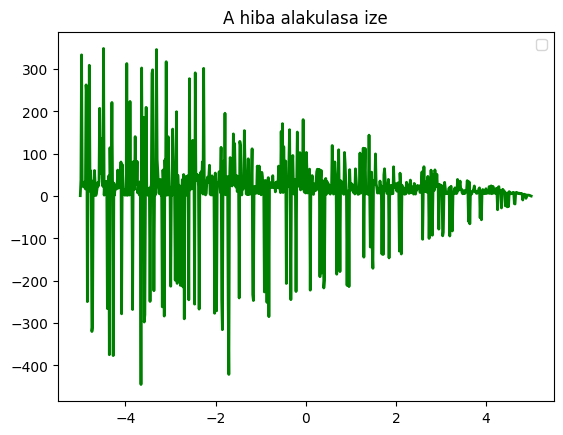

In [8]:
import matplotlib.pyplot as plt

ize.reverse()
revError = ize
t = np.linspace(-5, 5, num=training_count)
plt.plot(t, revError, "g", linewidth = 2)
plt.legend()

plt.title('A hiba alakulasa ize')
plt.show()

In [9]:
#####################
#validation
#####################
correct_classification_count = 0
for sample in range(validation_count):
    for node in range(H_dim):
        preActivation_H[node] = np.dot(validation_data[sample,:], weights_ItoH[:, node])
        postActivation_H[node] = sigmoidFunction(preActivation_H[node])

    preActivation_O = np.dot(postActivation_H, weights_HtoO)
    postActivation_O = sigmoidFunction(preActivation_O)

    if postActivation_O > 0.5:
        output = 1
    else:
        output = 0

    if output == validation_output[sample]:
        correct_classification_count += 1


In [10]:
print('Percentage of correct classifications:')
print(correct_classification_count*100/validation_count)

Percentage of correct classifications:
88.96321070234114


# **Megoldandó feladatok:**

1). Tanulmányozzuk a háló tanítását különböző tanítási együtthatókra. A két rétegre a tanítási együtthatókat külön-külön kell változtatni és grafikusan ábrázolni a hibát (költségfüggvényt) a tanító halmazra illetve a teszthalmazra.

 2) Tanulmányozzuk a háló viselkedését a rejtett rétegben levő neuronok számának a függvényében (ábrázolni a hibát a tanító és a teszthalmazra különböző neuron számra).

3) Különböző típusú aktiváló függvényt alkalmazva (legalább három típusú aktivációs függvényre) végezzük el a tanítást és a tesztelést. Melyik a jobb és miért?


# **Javasolt pluszpontos feladatok:**

4) A súlyok tanítására alkalmazzunk momentum kiegészítő tagot.

5) Az L1 és L2 regularizációs módszereket alkalmazva csökkentsük a neuroháló méretét, kivágva  a rejtett rétegből azokat a neuronokat, amelyek kimenete miden egyes elemre a tanítóhalmazból nulla körüli értéket vesz fel.

A mérések során tanulmanyozzuk a tultanítást és az eredményt ábrázoljuk grafiusan (hiba  ábrázolása a tanító és teszthalmazra).

In [15]:
# 1.
class DifferentialLearningRateMLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate_ItoH, learning_rate_HtoO):
        # Súlyok inicializálása
        self.weights_ItoH = np.random.uniform(-1, 1, (input_size, hidden_size))
        self.weights_HtoO = np.random.uniform(-1, 1, (hidden_size, output_size))
        self.learning_rate_ItoH = learning_rate_ItoH
        self.learning_rate_HtoO = learning_rate_HtoO

        # Bias inicializálása
        self.bias_hidden = np.random.uniform(-1, 1, (1, hidden_size))
        self.bias_output = np.random.uniform(-1, 1, (1, output_size))

    def feedforward(self, X):
        self.hidden = sigmoidFunction(np.dot(X, self.weights_ItoH) + self.bias_hidden)
        self.output = sigmoidFunction(np.dot(self.hidden, self.weights_HtoO) + self.bias_output)
        return self.output

    def backpropagation(self, X, y):
        # Hiba számítása
        error = y - self.output
        d_output = error * sigmoidFunctionDeriv(self.output)

        error_hidden = d_output.dot(self.weights_HtoO.T)
        d_hidden = error_hidden * sigmoidFunctionDeriv(self.hidden)

        # Súlyok és bias frissítése
        self.weights_HtoO += self.hidden.T.dot(d_output) * self.learning_rate_HtoO
        self.weights_ItoH += X.T.dot(d_hidden) * self.learning_rate_ItoH
        self.bias_output += np.sum(d_output, axis=0, keepdims=True) * self.learning_rate_HtoO
        self.bias_hidden += np.sum(d_hidden, axis=0, keepdims=True) * self.learning_rate_ItoH

        return error

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            self.feedforward(X)
            error = self.backpropagation(X, y)
        return np.mean(np.abs(error))

# Példa XOR adathalmaz
X = np.array([[0, 0, 1],
              [0, 1, 1],
              [1, 0, 1],
              [1, 1, 1]])
y = np.array([[0], [1], [1], [0]])

# Tanulási ráták beállítása és tanítás
model = DifferentialLearningRateMLP(input_size=3, hidden_size=4, output_size=1, learning_rate_ItoH=0.1, learning_rate_HtoO=0.2)
error = model.train(X, y, epochs=10000)
print(f"A tanítási folyamat hibája: {error}")


A tanítási folyamat hibája: 0.3173181359661938


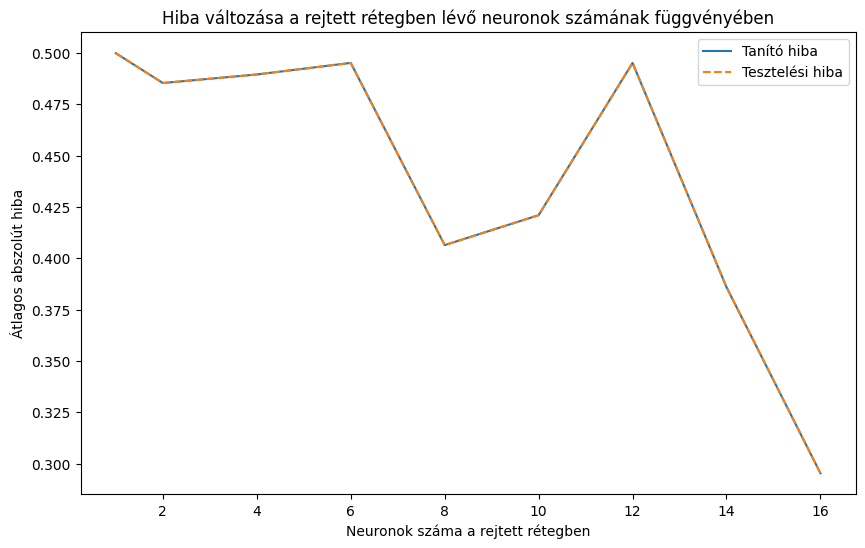

In [12]:
# 2.
import matplotlib.pyplot as plt

# Tanító és tesztelési folyamat definiálása
def train_and_test_neuron_numbers(X_train, y_train, X_test, y_test, neuron_numbers, epochs=1000):
    train_errors = []
    test_errors = []

    for neurons in neuron_numbers:
        model = DifferentialLearningRateMLP(input_size=3, hidden_size=neurons, output_size=1, learning_rate_ItoH=0.1, learning_rate_HtoO=0.2)
        model.train(X_train, y_train, epochs)

        # Tanító hiba számítása
        model.feedforward(X_train)
        train_error = np.mean(np.abs(y_train - model.output))
        train_errors.append(train_error)

        # Tesztelési hiba számítása
        model.feedforward(X_test)
        test_error = np.mean(np.abs(y_test - model.output))
        test_errors.append(test_error)

    return train_errors, test_errors

# Neuron számok definiálása
neuron_numbers = [1, 2, 4, 6, 8, 10, 12, 14, 16]

# XOR adathalmaz használata a tanításhoz és a "teszteléshez"
X = np.array([[0, 0, 1],
              [0, 1, 1],
              [1, 0, 1],
              [1, 1, 1]])
y = np.array([[0], [1], [1], [0]])

# Tanítás és tesztelés végrehajtása
train_errors, test_errors = train_and_test_neuron_numbers(X, y, X, y, neuron_numbers)

# Eredmények ábrázolása
plt.figure(figsize=(10, 6))
plt.plot(neuron_numbers, train_errors, label='Tanító hiba')
plt.plot(neuron_numbers, test_errors, label='Tesztelési hiba', linestyle='--')
plt.xlabel('Neuronok száma a rejtett rétegben')
plt.ylabel('Átlagos abszolút hiba')
plt.title('Hiba változása a rejtett rétegben lévő neuronok számának függvényében')
plt.legend()
plt.show()


Sigmoid aktiválási függvény hibája: 0.04376319037072042
ReLU aktiválási függvény hibája: 0.5
Tanh aktiválási függvény hibája: 0.012280241701130661


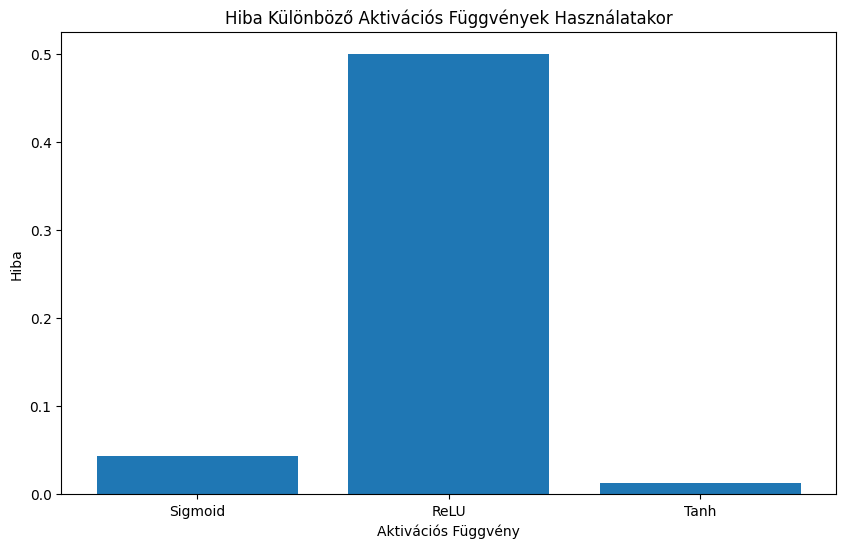

In [16]:
# 3.
# Aktivációs függvények és deriváltjaik definíciója
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1.0 - np.tanh(x)**2

# Aktivációs függvények listájának definiálása
activation_functions = [
    (sigmoid, sigmoid_derivative, 'Sigmoid'),
    (relu, relu_derivative, 'ReLU'),
    (tanh, tanh_derivative, 'Tanh')
]

# Módosítjuk az MLP osztályt az új aktivációs függvények támogatására
# Javított ModifiedMLP osztály a train metódussal
class ModifiedMLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, activation_function, activation_derivative):
        self.weights_ItoH = np.random.uniform(-1, 1, (input_size, hidden_size))
        self.weights_HtoO = np.random.uniform(-1, 1, (hidden_size, output_size))
        self.learning_rate = learning_rate
        self.activation = activation_function
        self.activation_derivative = activation_derivative
        self.bias_hidden = np.random.uniform(-1, 1, (1, hidden_size))
        self.bias_output = np.random.uniform(-1, 1, (1, output_size))

    def feedforward(self, X):
        self.hidden = self.activation(np.dot(X, self.weights_ItoH) + self.bias_hidden)
        self.output = self.activation(np.dot(self.hidden, self.weights_HtoO) + self.bias_output)

    def backpropagation(self, X, y):
        error = y - self.output
        d_output = error * self.activation_derivative(self.output)
        error_hidden = d_output.dot(self.weights_HtoO.T)
        d_hidden = error_hidden * self.activation_derivative(self.hidden)
        self.weights_HtoO += self.hidden.T.dot(d_output) * self.learning_rate
        self.weights_ItoH += X.T.dot(d_hidden) * self.learning_rate
        self.bias_output += np.sum(d_output, axis=0, keepdims=True) * self.learning_rate
        self.bias_hidden += np.sum(d_hidden, axis=0, keepdims=True) * self.learning_rate

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            self.feedforward(X)
            self.backpropagation(X, y)


# Újra futtatjuk a tanítást és tesztelést különböző aktivációs függvényekkel
errors = []
for activation, derivative, name in activation_functions:
    model = ModifiedMLP(input_size=3, hidden_size=4, output_size=1, learning_rate=0.1, activation_function=activation, activation_derivative=derivative)
    model.train(X, y, epochs=10000)
    # Hiba számítása a tanítási adathalmazon
    model.feedforward(X)
    train_error = np.mean(np.abs(y - model.output))
    errors.append((name, train_error))

# Eredmények kiírása
for name, error in errors:
    print(f"{name} aktiválási függvény hibája: {error}")

# Eredmények vizualizációja
labels, values = zip(*errors)
plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.xlabel('Aktivációs Függvény')
plt.ylabel('Hiba')
plt.title('Hiba Különböző Aktivációs Függvények Használatakor')
plt.show()

In [17]:
# 4.
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

class MomentumMLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate, momentum, activation_function=sigmoid, activation_derivative=sigmoid_derivative):
        self.weights_ItoH = np.random.uniform(-1, 1, (input_size, hidden_size))
        self.weights_HtoO = np.random.uniform(-1, 1, (hidden_size, output_size))
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.activation_function = activation_function
        self.activation_derivative = activation_derivative
        self.bias_hidden = np.random.uniform(-1, 1, (1, hidden_size))
        self.bias_output = np.random.uniform(-1, 1, (1, output_size))

        # Momentum változók inicializálása
        self.velocity_ItoH = np.zeros((input_size, hidden_size))
        self.velocity_HtoO = np.zeros((hidden_size, output_size))
        self.velocity_bias_hidden = np.zeros((1, hidden_size))
        self.velocity_bias_output = np.zeros((1, output_size))

    # További metódusok: feedforward, backpropagation, train, stb.


    def feedforward(self, X):
        self.hidden = sigmoid(np.dot(X, self.weights_ItoH) + self.bias_hidden)
        self.output = sigmoid(np.dot(self.hidden, self.weights_HtoO) + self.bias_output)

    def backpropagation(self, X, y):
        error = y - self.output
        d_output = error * sigmoid_derivative(self.output)

        error_hidden = d_output.dot(self.weights_HtoO.T)
        d_hidden = error_hidden * sigmoid_derivative(self.hidden)

        gradient_HtoO = self.hidden.T.dot(d_output)
        gradient_ItoH = X.T.dot(d_hidden)

        # Momentum alkalmazása a súlyok frissítésére
        self.velocity_ItoH = self.momentum * self.velocity_ItoH + self.learning_rate * gradient_ItoH
        self.velocity_HtoO = self.momentum * self.velocity_HtoO + self.learning_rate * gradient_HtoO
        self.weights_ItoH += self.velocity_ItoH
        self.weights_HtoO += self.velocity_HtoO

        # Momentum alkalmazása a bias frissítésére
        self.velocity_bias_hidden = self.momentum * self.velocity_bias_hidden + self.learning_rate * np.sum(d_hidden, axis=0, keepdims=True)
        self.velocity_bias_output = self.momentum * self.velocity_bias_output + self.learning_rate * np.sum(d_output, axis=0, keepdims=True)
        self.bias_hidden += self.velocity_bias_hidden
        self.bias_output += self.velocity_bias_output

    def train(self, X, y, epochs):
        for epoch in range(epochs):
            self.feedforward(X)
            self.backpropagation(X, y)

# XOR probléma adathalmaz
X = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
y = np.array([[0], [1], [1], [0]])

# Modell inicializálása és tanítása
model = MomentumMLP(input_size=3, hidden_size=4, output_size=1, learning_rate=0.1, momentum=0.9)
model.train(X, y, epochs=10000)

# Ellenőrizzük a hálózat teljesítményét
model.feedforward(X)
print("Kimenet a tanítás után:", model.output)


Kimenet a tanítás után: [[0.01123929]
 [0.98914969]
 [0.99045605]
 [0.01023334]]


In [18]:
# 5.
class RegularizedMLP(MomentumMLP):
    def __init__(self, input_size, hidden_size, output_size, learning_rate, activation_function, activation_derivative, momentum=0.9, lambda_l1=0.01, lambda_l2=0.01):
        super().__init__(input_size, hidden_size, output_size, learning_rate, activation_function, activation_derivative, momentum)
        self.lambda_l1 = lambda_l1
        self.lambda_l2 = lambda_l2

    def backpropagation(self, X, y):
        # Alap backpropagation
        super().backpropagation(X, y)

        # L1 és L2 regularizáció alkalmazása
        l1_penalty = self.lambda_l1 * np.sign(self.weights_ItoH)
        l2_penalty = self.lambda_l2 * self.weights_ItoH
        self.weights_ItoH -= (l1_penalty + l2_penalty) * self.learning_rate

        l1_penalty = self.lambda_l1 * np.sign(self.weights_HtoO)
        l2_penalty = self.lambda_l2 * self.weights_HtoO
        self.weights_HtoO -= (l1_penalty + l2_penalty) * self.learning_rate

    def prune_neurons(self):
        # Neuronok kivágása, ha a rejtett réteg aktivációi közel nullák minden tanító adatra
        activations = self.hidden.mean(axis=0)  # Átlagos aktivációk számítása mintákon
        to_prune = np.abs(activations) < 1e-5  # Kivágandó neuronok azonosítása
        self.weights_ItoH = self.weights_ItoH[:, ~to_prune]  # Bemeneti-réteghez-rejtett-réteg súlyok frissítése
        self.weights_HtoO = self.weights_HtoO[~to_prune, :]  # Rejtett-réteghez-kimeneti-réteg súlyok frissítése
        self.bias_hidden = self.bias_hidden[:, ~to_prune]  # Bias frissítése


model = RegularizedMLP(input_size=3, hidden_size=4, output_size=1, learning_rate=0.1, momentum=0.9, activation_function=sigmoid, activation_derivative=sigmoid_derivative, lambda_l1=0.01, lambda_l2=0.01)